<a href="https://colab.research.google.com/github/KamilBartosik/CNN_NaturalDisasters/blob/main/CNN_NaturalDisasters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import splitfolders
import pathlib
import random
import imagesize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
#from keras.applications.vgg16 import VGG16
#from sklearn.metrics import classification_report, confusion_matrix

In [4]:
dataset = '/content/gdrive/MyDrive/MachineLearning/Datasets/Natural_Disasters/dataset/'
dataset = pathlib.Path(dataset)

In [5]:
classes = [i for i in os.listdir(dataset)]
classes_count = []

for i in os.listdir(dataset):
  i = [x for x in os.listdir(f'{dataset}/{i}') if x.endswith('.jpg')]
  classes_count.append(len(i))

Total images: 4428
Total Earthquake images: 1350
Total Cyclone images: 928
Total Flood images: 1073
Total Wildfire images: 1077


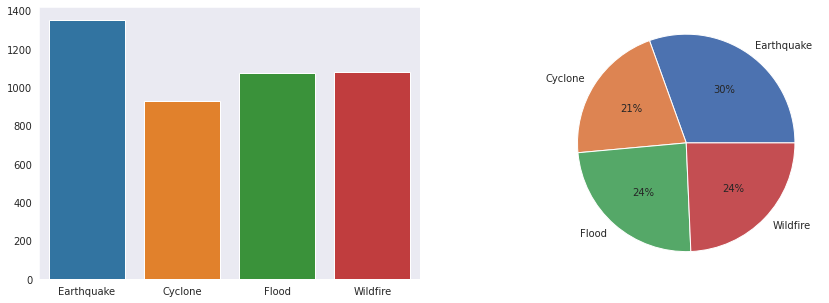

In [6]:
print(f'Total images: {sum(classes_count)}')
for i in range(0, len(classes)):
  print(f'Total {classes[i]} images: {classes_count[i]}')

sns.set_style("dark")
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(x=classes, y=classes_count)

plt.subplot(1,2,2)
plt.pie(x=classes_count, labels=classes, colors=sns.color_palette('deep'), autopct='%.0f%%')
plt.show()

Image dimensions: (800, 1200, 3)


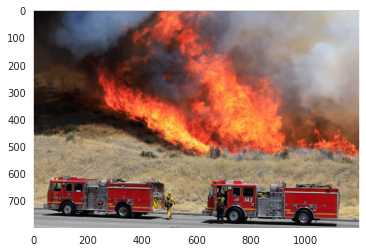

In [7]:
sample_img = cv2.imread(f'{dataset}/Wildfire/37.jpg')
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

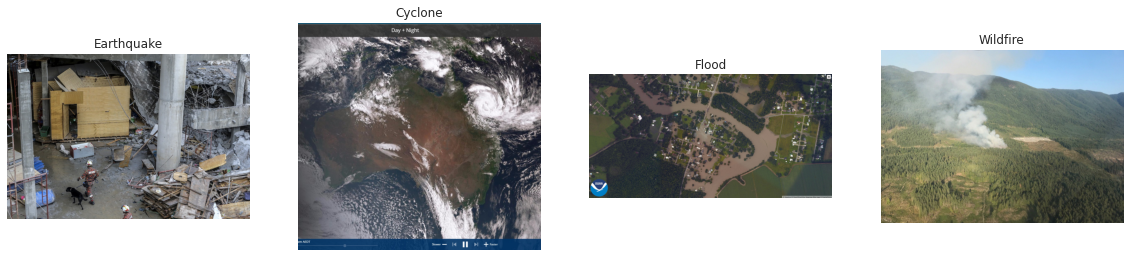

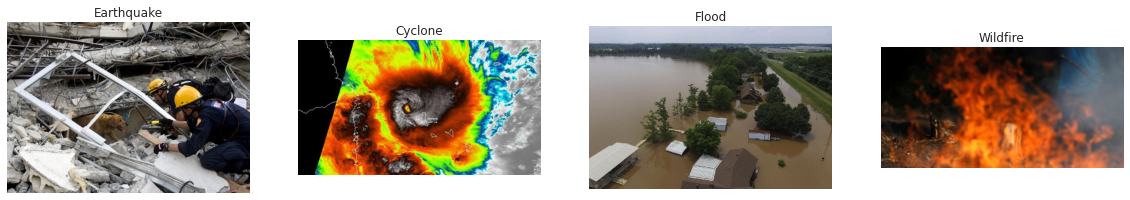

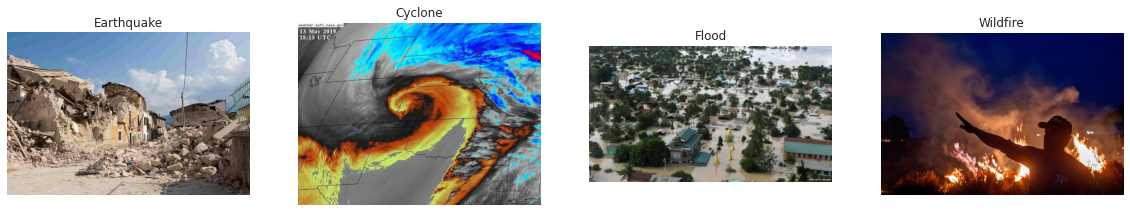

In [8]:
def load_random_img(file, label):
  plt.figure(figsize=(20,20))
  i=0

  for label in classes:
    i+=1
    plt.subplot(1, 4, i)

    path = random.choice(os.listdir(f'{file}/{label}'))
    img_path = os.path.join(f'{file}/{label}', path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.title(label)
    plt.imshow(img)
    plt.axis('off')

for i in range(3):
  load_random_img(dataset, classes)

In [9]:
def get_image_resolutions(label):
  imgs = [x for x in os.listdir(f'{dataset}/{label}') if x.endswith('.jpg')]
  img_meta = {}
  for x in imgs:
    img_meta[x] = imagesize.get(f'{dataset}/{label}/{x}')

  return img_meta

imgs_meta = [get_image_resolutions(str(i)) for i in classes]

In [10]:
dframes = []

for i in range(0, 4):
  img_meta_df = pd.DataFrame.from_dict([imgs_meta[i]]).T.reset_index().set_axis(['Image', 'Size'], axis='columns', inplace=False)
  img_meta_df.insert(0, 'Label', classes[i], allow_duplicates=True)
  dframes.append(img_meta_df)

df = pd.concat(dframes, ignore_index=True)
df[['Width', 'Height']] = pd.DataFrame(df['Size'].tolist(), index=df.index)
df['Aspect Ratio'] = round(df['Width'] / df['Height'], 2)

df.head()

,Label,Image,Size,Width,Height,Aspect Ratio
0,Earthquake,871.jpg,"(1010, 505)",1010,505,2.00
1,Earthquake,703.jpg,"(609, 343)",609,343,1.78
2,Earthquake,1128.jpg,"(1300, 956)",1300,956,1.36
3,Earthquake,100.jpg,"(2400, 1600)",2400,1600,1.50
4,Earthquake,79.jpg,"(604, 453)",604,453,1.33


In [11]:
df.describe()

,Width,Height,Aspect Ratio
count,4428.000000,4428.000000,4428.000000
mean,1128.598690,762.142502,1.553141
std,944.295283,745.200266,0.309202
min,170.000000,113.000000,0.460000
25%,640.000000,406.750000,1.420000
50%,852.000000,547.000000,1.500000
75%,1200.000000,798.000000,1.780000
max,9232.000000,9400.000000,4.250000


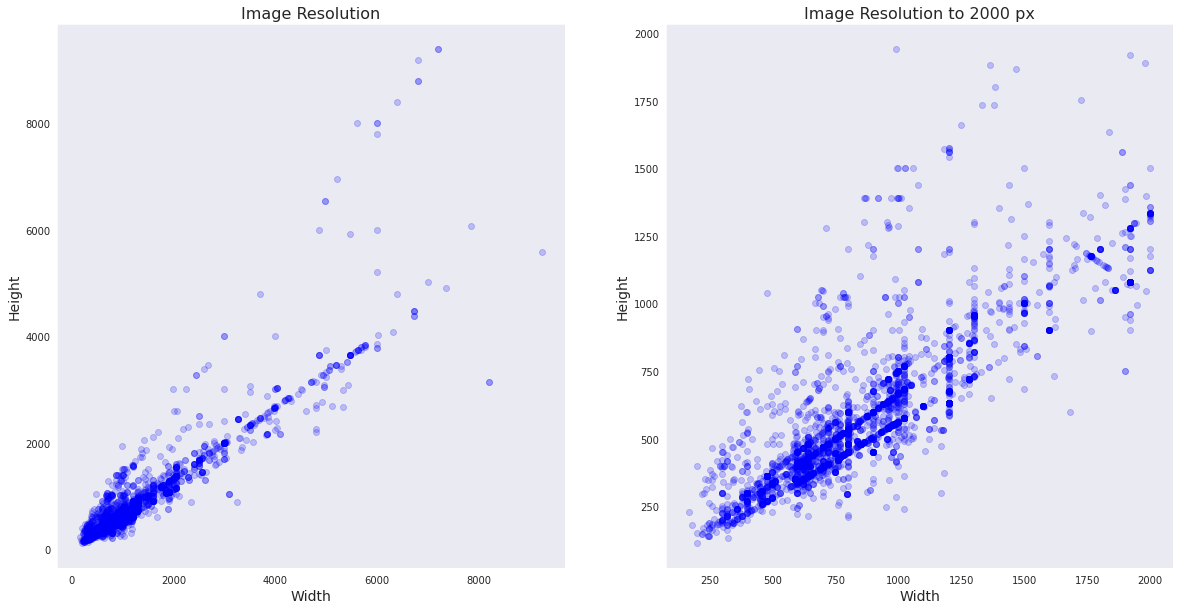

In [12]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
plt.scatter(df.Width, df.Height, color='blue', alpha=0.2)
plt.title('Image Resolution', size=16)
plt.xlabel('Width', size=14)
plt.ylabel('Height', size=14)

plt.subplot(1,2,2)
df2 = df.loc[(df.Width <= 2000) & (df.Height <= 2000)]
plt.scatter(df2.Width, df2.Height, color='blue', alpha=0.2)
plt.title('Image Resolution to 2000 px', size=16)
plt.xlabel('Width', size=14)
plt.ylabel('Height', size=14)

plt.show()

In [13]:
splitfolders.ratio(dataset, 'splited', ratio=(.75, .15, .1))

Copying files: 4428 files [00:28, 155.55 files/s]


In [35]:
width, height = 300, 200
img_size = (width, height)
batch_size = 32

In [36]:
img_gen = ImageDataGenerator(rescale=1./255)

In [37]:
train_set = img_gen.flow_from_directory('splited/train',
                                          target_size=img_size,
                                          batch_size=batch_size,
                                          class_mode='categorical')

val_set = img_gen.flow_from_directory('splited/val',
                                           target_size=img_size,
                                           batch_size=batch_size,
                                           class_mode='categorical')

test_set = img_gen.flow_from_directory('splited/test',
                                           target_size=img_size,
                                           batch_size=batch_size,
                                           class_mode='categorical')

Found 3319 images belonging to 4 classes.
Found 662 images belonging to 4 classes.
Found 447 images belonging to 4 classes.


In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation='relu', padding='valid', input_shape=(height, width, 3)),
    tf.keras.layers.BatchNormalization(axis=3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='valid'),
    tf.keras.layers.BatchNormalization(axis=3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='valid'),
    tf.keras.layers.BatchNormalization(axis=3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [39]:
model.compile(optimizer=Adam(0.003), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 298, 16)      448       
                                                                 
 batch_normalization_6 (Batc  (None, 198, 298, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 99, 149, 16)      0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 99, 149, 16)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 147, 32)       4640      
                                                                 
 batch_normalization_7 (Batc  (None, 97, 147, 32)     

In [40]:
model_path = "/content/gdrive/MyDrive/MachineLearning/Models/Natural_Disasters"

checkpointer = ModelCheckpoint(filepath=f'{model_path}/model_1.hdf5',
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.0005)

callbacks=[early_stopping, reduce_lr, checkpointer]

In [41]:
history = model.fit(train_set, epochs=50, validation_data=val_set, callbacks=callbacks)

Epoch 1/50
104/104 [==============================] - ETA: 0s - loss: 7.1792 - accuracy: 0.4881
Epoch 1: val_accuracy improved from -inf to 0.29154, saving model to /content/gdrive/MyDrive/MachineLearning/Models/Natural_Disasters/model_1.hdf5
104/104 [==============================] - 89s 852ms/step - loss: 7.1792 - accuracy: 0.4881 - val_loss: 9.1914 - val_accuracy: 0.2915 - lr: 0.0030
Epoch 2/50
104/104 [==============================] - ETA: 0s - loss: 1.0512 - accuracy: 0.5456
Epoch 2: val_accuracy improved from 0.29154 to 0.32175, saving model to /content/gdrive/MyDrive/MachineLearning/Models/Natural_Disasters/model_1.hdf5
104/104 [==============================] - 88s 855ms/step - loss: 1.0512 - accuracy: 0.5456 - val_loss: 4.0613 - val_accuracy: 0.3218 - lr: 0.0030
Epoch 3/50
104/104 [==============================] - ETA: 0s - loss: 0.9477 - accuracy: 0.6125
Epoch 3: val_accuracy did not improve from 0.32175
104/104 [==============================] - 88s 846ms/step - loss: 0.94

In [30]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

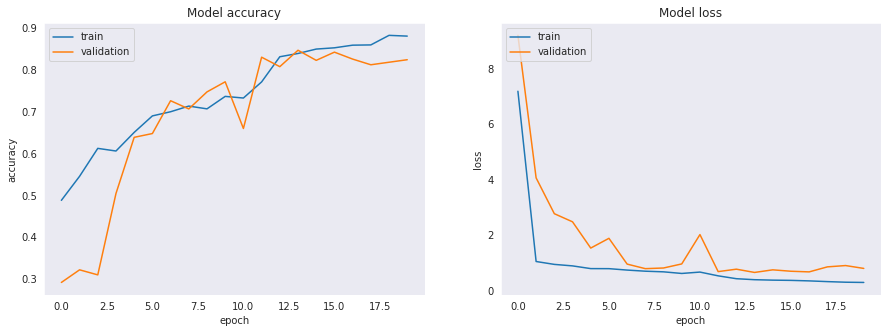

In [42]:
model.load_weights(f'{model_path}/model_1.hdf5')
plot_train_history(history)

In [43]:
score = model.evaluate(test_set)

14/14 [==============================] - 10s 682ms/step - loss: 0.5650 - accuracy: 0.8322
